In [1]:
#!pip install pyforest
from pyforest import *
from geopy.distance import geodesic 
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
from fancyimpute import KNN
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Working Directory
os.getcwd()

'/Users/divyanggor/Documents/Study/Online_Course/Edwisor/Project'

In [3]:
#Read data as data frame from CSV
train_cab = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0104/train_cab.zip")
test_cab = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0104/test.zip")

In [4]:
#View top 5 rows of data
train_cab.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
test_cab.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
#Data Information
train_cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


In [7]:
test_cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


## Data Type

In [8]:
train_cab.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [9]:
test_cab.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [10]:
#Change data type from object to datetime /float64
train_cab["pickup_datetime"] = pd.to_datetime(train_cab.pickup_datetime, errors = 'coerce')
train_cab["fare_amount"] = pd.to_numeric(train_cab.fare_amount, errors = 'coerce')
test_cab["pickup_datetime"] = pd.to_datetime(test_cab.pickup_datetime, errors = 'coerce')

In [11]:
train_cab.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [12]:
test_cab.dtypes

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [13]:
train_cab.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [14]:
#Fare amount can't be negative/zero 
train_cab = train_cab.drop(train_cab[train_cab['fare_amount']<=0].index, axis = 0)
# Passenger_count must be positive integer 1, 2, 3, 4, 5 or 6
train_cab = train_cab.drop(train_cab[train_cab['passenger_count']>6].index, axis =0)
train_cab = train_cab.drop(train_cab[train_cab['passenger_count']<1].index, axis =0)
train_cab['passenger_count'] = train_cab['passenger_count'].round(0)
#latitude can never be more than 180
train_cab = train_cab.drop(train_cab[train_cab['pickup_latitude']>180].index, axis =0)

In [15]:
train_cab.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15960.000000,15984.000000,15984.000000,15984.000000,15984.000000,15929.000000
mean,15.049085,-72.473455,39.898063,-72.463744,39.898594,1.649633
std,431.564950,10.543141,6.187131,10.570907,6.186759,1.265923
min,0.010000,-74.438233,-74.006893,-74.429332,-74.006377,1.000000
25%,6.000000,-73.992157,40.734941,-73.991181,40.734711,1.000000
50%,8.500000,-73.981697,40.752633,-73.980166,40.753583,1.000000
75%,12.500000,-73.966834,40.767395,-73.963643,40.768027,2.000000
max,54343.000000,40.766125,41.366138,40.802437,41.366138,6.000000


# Missing Value Analysis

In [16]:
train_cab.isnull().sum()

fare_amount          24
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [17]:
test_cab.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [18]:
#Missing Value Analysis
missing_value = pd.DataFrame(train_cab.isnull().sum())
missing_value = missing_value.reset_index()
missing_value = missing_value.rename(columns = {'index':'variables',0:'missing_percentage'})
missing_value['missing_percentage']=(missing_value['missing_percentage']/len(train_cab))*100
missing_value = missing_value.sort_values('missing_percentage', ascending= False)
missing_value

,variables,missing_percentage
6,passenger_count,0.344094
0,fare_amount,0.150150
1,pickup_datetime,0.006256
2,pickup_longitude,0.000000
3,pickup_latitude,0.000000
4,dropoff_longitude,0.000000
5,dropoff_latitude,0.000000


In [19]:
#imputation_passenger_count
#Original Value = 1
#Mean = 1.3142578044948425
#Median = 1.0
#Mode = 1.0
#KNN = 1.38
train_cab['passenger_count'].loc[100] = np.nan
train_cab['passenger_count'].loc[100]
#We will impute passenger_count by KNN Imputation

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


nan

In [20]:
print('Mean: ',train_cab['passenger_count'].mean())
print('Median:',train_cab['passenger_count'].median())
print('Mode:', train_cab['passenger_count'].mode())

Mean:  1.6496735308890005
Median: 1.0
Mode: 0    1.0
dtype: float64


In [21]:
#Null Values Count
pd.DataFrame(train_cab.isnull().sum())

,0
fare_amount,24
pickup_datetime,1
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,56


In [22]:
train_cab = train_cab.dropna(subset = ['pickup_datetime'])
pd.DataFrame(train_cab.isnull().sum())

,0
fare_amount,24
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,56


In [23]:
#Imputation fare_amount
#actual = 10.0
#Mean = 15.409399247348453
#Median = 8.5
#Mode = 6.5
#KNN = 10.068677622209403
print(train_cab['fare_amount'].loc[100] )
train_cab['fare_amount'].loc[100]=np.nan
train_cab['fare_amount'].loc[100] 

10.0


nan

In [24]:
print('Mean: ',train_cab['fare_amount'].mean())
print('Median: ', train_cab['fare_amount'].median())
print('Mode', train_cab['fare_amount'].mode())

Mean:  15.049624013034057
Median:  8.5
Mode 0    6.5
dtype: float64


In [25]:
train_cab_pickup_datetime = train_cab['pickup_datetime']

In [26]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']
train_cab = pd.DataFrame(KNN(k = 3).fit_transform(train_cab.drop('pickup_datetime',axis = 1)),columns = columns, index = train_cab.index)

Imputing row 1/15983 with 0 missing, elapsed time: 141.803
Imputing row 101/15983 with 2 missing, elapsed time: 144.831
Imputing row 201/15983 with 0 missing, elapsed time: 145.443
Imputing row 301/15983 with 0 missing, elapsed time: 145.591
Imputing row 401/15983 with 0 missing, elapsed time: 145.718
Imputing row 501/15983 with 0 missing, elapsed time: 145.848
Imputing row 601/15983 with 0 missing, elapsed time: 145.894
Imputing row 701/15983 with 0 missing, elapsed time: 146.038
Imputing row 801/15983 with 0 missing, elapsed time: 146.156
Imputing row 901/15983 with 0 missing, elapsed time: 146.257
Imputing row 1001/15983 with 0 missing, elapsed time: 146.286
Imputing row 1101/15983 with 0 missing, elapsed time: 146.286
Imputing row 1201/15983 with 0 missing, elapsed time: 146.316
Imputing row 1301/15983 with 0 missing, elapsed time: 146.317
Imputing row 1401/15983 with 0 missing, elapsed time: 146.386
Imputing row 1501/15983 with 0 missing, elapsed time: 146.399
Imputing row 1601/15

In [27]:
train_cab['fare_amount'].loc[100] 

11.494300428658434

In [28]:
train_cab['passenger_count'].loc[100] 

1.3891588624109557

In [29]:
train_cab['passenger_count'] = train_cab['passenger_count'].round(0)

In [30]:
train_cab['pickup_datetime'] = train_cab_pickup_datetime
pd.DataFrame(train_cab.isnull().sum())

,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
pickup_datetime,0


# Outliner Analysis

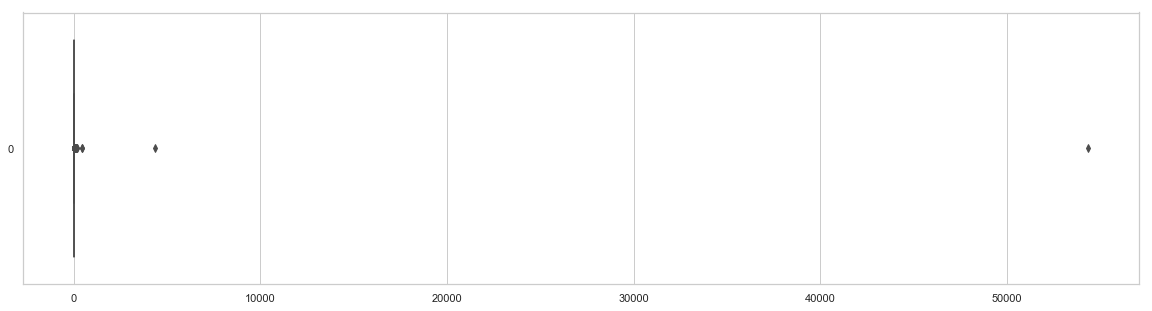

In [31]:
sns.set(style="whitegrid")
%matplotlib inline
plt.figure(figsize = (20,5))
sns.boxplot(data=train_cab['fare_amount'],orient='h')

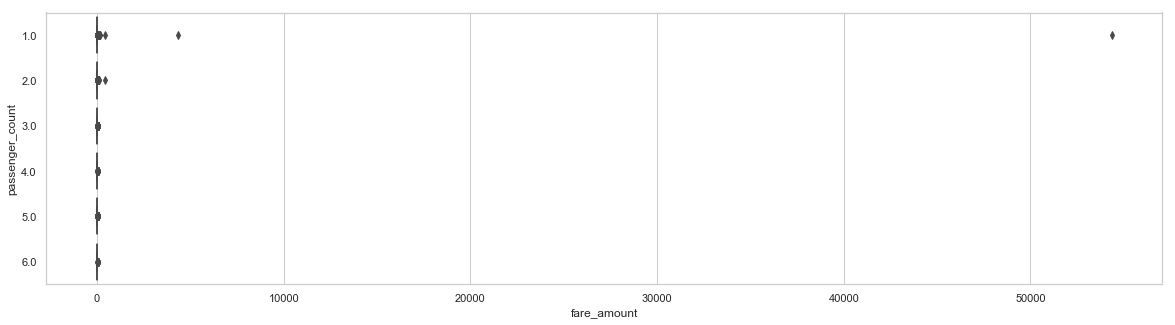

In [32]:
plt.figure(figsize = (20,5))
sns.boxplot(x=train_cab['fare_amount'],y=train_cab['passenger_count'],data=train_cab,orient='h')
#sns.boxplot(data=temp,x=train['fare_amount'],y=train['passenger_count'],orient = 'h', palette="colorblind",width=0.9)

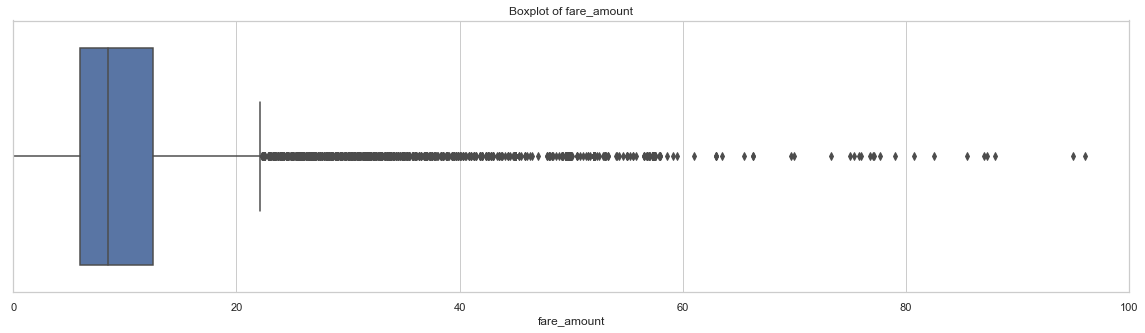

In [33]:
plt.figure(figsize=(20,5))
plt.xlim(0,100) 
sns.boxplot(x=train_cab['fare_amount'],data=train_cab,orient='h') 
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

In [34]:
#Outliner Analysis
q75, q25 = np.percentile(train_cab['fare_amount'], [75 ,25])

#Calculate IQR
iqr = q75 - q25

#Calculate inner and outer fence
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)


#Replace with NA
train_cab.fare_amount[train_cab.fare_amount < minimum] = np.nan
train_cab.fare_amount[train_cab.fare_amount > maximum] = np.nan
pd.DataFrame(train_cab.isnull().sum())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0
fare_amount,1396
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
pickup_datetime,0


In [35]:
train_cab_pickup_datetime = train_cab['pickup_datetime']
#temp_cab = train_cab
#actual 17.3
train_cab['fare_amount'].loc[150]=np.nan

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
#KNN for NA values
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']
train_cab = pd.DataFrame(KNN(k = 50).fit_transform(train_cab.drop('pickup_datetime',axis = 1)),columns = columns, index = train_cab.index);

Imputing row 1/15983 with 0 missing, elapsed time: 104.580
Imputing row 101/15983 with 0 missing, elapsed time: 105.375
Imputing row 201/15983 with 0 missing, elapsed time: 106.137
Imputing row 301/15983 with 0 missing, elapsed time: 106.532
Imputing row 401/15983 with 0 missing, elapsed time: 106.793
Imputing row 501/15983 with 0 missing, elapsed time: 107.137
Imputing row 601/15983 with 0 missing, elapsed time: 107.648
Imputing row 701/15983 with 1 missing, elapsed time: 107.980
Imputing row 801/15983 with 1 missing, elapsed time: 108.625
Imputing row 901/15983 with 0 missing, elapsed time: 108.855
Imputing row 1001/15983 with 1 missing, elapsed time: 109.033
Imputing row 1101/15983 with 0 missing, elapsed time: 109.928
Imputing row 1201/15983 with 0 missing, elapsed time: 110.845
Imputing row 1301/15983 with 0 missing, elapsed time: 111.723
Imputing row 1401/15983 with 0 missing, elapsed time: 112.565
Imputing row 1501/15983 with 0 missing, elapsed time: 113.839
Imputing row 1601/15

Imputing row 13501/15983 with 0 missing, elapsed time: 153.648
Imputing row 13601/15983 with 0 missing, elapsed time: 153.684
Imputing row 13701/15983 with 0 missing, elapsed time: 153.701
Imputing row 13801/15983 with 0 missing, elapsed time: 153.762
Imputing row 13901/15983 with 0 missing, elapsed time: 153.780
Imputing row 14001/15983 with 0 missing, elapsed time: 153.811
Imputing row 14101/15983 with 0 missing, elapsed time: 153.830
Imputing row 14201/15983 with 0 missing, elapsed time: 153.857
Imputing row 14301/15983 with 0 missing, elapsed time: 154.039
Imputing row 14401/15983 with 0 missing, elapsed time: 154.112
Imputing row 14501/15983 with 0 missing, elapsed time: 154.455
Imputing row 14601/15983 with 0 missing, elapsed time: 154.500
Imputing row 14701/15983 with 0 missing, elapsed time: 154.521
Imputing row 14801/15983 with 1 missing, elapsed time: 154.530
Imputing row 14901/15983 with 0 missing, elapsed time: 154.554
Imputing row 15001/15983 with 0 missing, elapsed time: 

In [37]:
train_cab['fare_amount'].loc[150]

16.16393742083369

In [38]:
train_cab['pickup_datetime']=train_cab_pickup_datetime

In [39]:
train_cab.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15 17:26:21+00:00
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05 16:52:16+00:00
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18 00:35:00+00:00
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21 04:30:42+00:00
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09 07:51:00+00:00


In [40]:
pd.DataFrame(train_cab.isnull().sum())

,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
pickup_datetime,0


# Feature Engineering

In [41]:
train_cab['year'] = train_cab['pickup_datetime'].apply(lambda row: row.year)
train_cab["month"] = train_cab["pickup_datetime"].apply(lambda row: row.month)
train_cab["day_of_week"] = train_cab["pickup_datetime"].apply(lambda row: row.dayofweek)
train_cab["hour"] = train_cab["pickup_datetime"].apply(lambda row: row.hour)

In [42]:
test_cab['year'] = test_cab['pickup_datetime'].apply(lambda row: row.year)
test_cab["month"] = test_cab["pickup_datetime"].apply(lambda row: row.month)
test_cab["day_of_week"] = test_cab["pickup_datetime"].apply(lambda row: row.dayofweek)
test_cab["hour"] = test_cab["pickup_datetime"].apply(lambda row: row.hour)


In [43]:
test_cab.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21


In [44]:
train_cab.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime,year,month,day_of_week,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15 17:26:21+00:00,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05 16:52:16+00:00,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18 00:35:00+00:00,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21 04:30:42+00:00,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09 07:51:00+00:00,2010,3,1,7


In [45]:
train_cab['geodesic']=train_cab.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis=1)
test_cab['geodesic']=test_cab.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis=1)

In [46]:
train_cab.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime,year,month,day_of_week,hour,geodesic
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15 17:26:21+00:00,2009,6,0,17,1.029601
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05 16:52:16+00:00,2010,1,1,16,8.443441
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18 00:35:00+00:00,2011,8,3,0,1.389132
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21 04:30:42+00:00,2012,4,5,4,2.795790
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09 07:51:00+00:00,2010,3,1,7,1.998338


In [47]:
train_cab.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime,year,month,day_of_week,hour,geodesic
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15 17:26:21+00:00,2009,6,0,17,1.029601
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05 16:52:16+00:00,2010,1,1,16,8.443441
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18 00:35:00+00:00,2011,8,3,0,1.389132
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21 04:30:42+00:00,2012,4,5,4,2.795790
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09 07:51:00+00:00,2010,3,1,7,1.998338


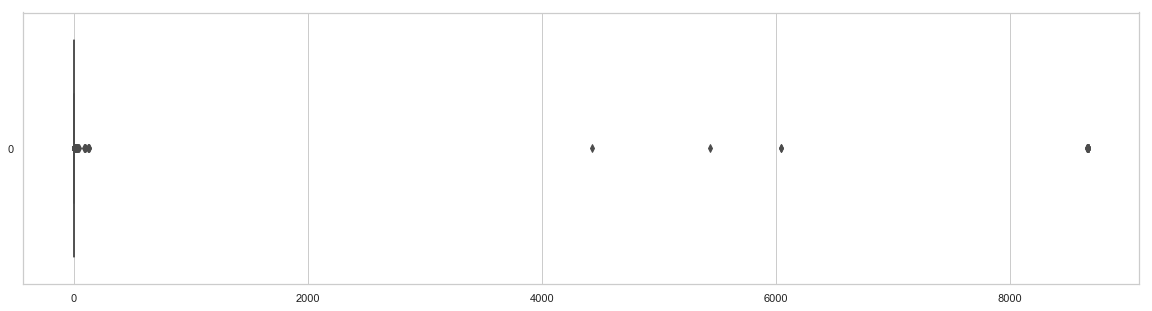

In [48]:
sns.set(style="whitegrid")
%matplotlib inline
plt.figure(figsize = (20,5))
sns.boxplot(data=train_cab['geodesic'],orient='h')

In [49]:
train_cab.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,geodesic
count,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000
mean,9.318769,-72.473361,39.898011,-72.463649,39.898540,1.650441,2011.732779,6.262154,3.033035,13.494588,15.013334
std,4.293613,10.543464,6.187321,10.571230,6.186948,1.265426,1.867124,3.447368,1.968920,6.520768,310.989801
min,0.010000,-74.438233,-74.006893,-74.429332,-74.006377,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992157,40.734943,-73.991182,40.734708,1.000000,2010.000000,3.000000,1.000000,9.000000,1.216312
50%,8.500000,-73.981696,40.752633,-73.980165,40.753582,1.000000,2012.000000,6.000000,3.000000,14.000000,2.125702
75%,12.000000,-73.966834,40.767398,-73.963643,40.768027,2.000000,2013.000000,9.000000,5.000000,19.000000,3.857545
max,22.100000,40.766125,41.366138,40.802437,41.366138,6.000000,2015.000000,12.000000,6.000000,23.000000,8667.884139


In [50]:
#Outliner Analysis
q75, q25 = np.percentile(train_cab['geodesic'], [75 ,25])

#Calculate IQR
iqr = q75 - q25

#Calculate inner and outer fence
minimum = q25 - (iqr*1.5)
maximum = q75 + (iqr*1.5)


#Replace with NA
train_cab.geodesic[train_cab.geodesic < minimum] = np.nan
train_cab.geodesic[train_cab.geodesic > maximum] = np.nan
pd.DataFrame(train_cab.isnull().sum())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
pickup_datetime,0
year,0
month,0
day_of_week,0


In [51]:
#outliner Analysis
#Actual Value =1.1734217770759794
#Mean = 2.3812342631431775
#Median =1.9334082879643537
#Mode = 0.0
#KNN = 
train_cab['geodesic'].loc[200] = np.nan

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
print("Mean", train_cab['geodesic'].mean())
print("Median", train_cab['geodesic'].median())
print("Mode", train_cab['geodesic'].mode()[0])

Mean 2.3813169956923983
Median 1.9335967065951096
Mode 0.0


In [53]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count','year','month','day_of_week','hours','geodesic']
train_cab = pd.DataFrame(KNN(k = 5).fit_transform(train_cab.drop('pickup_datetime',axis = 1)),columns = columns, index = train_cab.index);

Imputing row 1/15983 with 0 missing, elapsed time: 113.756
Imputing row 101/15983 with 0 missing, elapsed time: 116.295
Imputing row 201/15983 with 1 missing, elapsed time: 116.351
Imputing row 301/15983 with 0 missing, elapsed time: 116.394
Imputing row 401/15983 with 0 missing, elapsed time: 116.499
Imputing row 501/15983 with 0 missing, elapsed time: 116.555
Imputing row 601/15983 with 0 missing, elapsed time: 116.587
Imputing row 701/15983 with 1 missing, elapsed time: 116.644
Imputing row 801/15983 with 1 missing, elapsed time: 116.710
Imputing row 901/15983 with 0 missing, elapsed time: 116.919
Imputing row 1001/15983 with 1 missing, elapsed time: 116.951
Imputing row 1101/15983 with 0 missing, elapsed time: 117.057
Imputing row 1201/15983 with 0 missing, elapsed time: 117.130
Imputing row 1301/15983 with 0 missing, elapsed time: 117.218
Imputing row 1401/15983 with 0 missing, elapsed time: 117.357
Imputing row 1501/15983 with 0 missing, elapsed time: 117.446
Imputing row 1601/15

Imputing row 13401/15983 with 0 missing, elapsed time: 143.387
Imputing row 13501/15983 with 0 missing, elapsed time: 143.632
Imputing row 13601/15983 with 0 missing, elapsed time: 143.737
Imputing row 13701/15983 with 0 missing, elapsed time: 143.836
Imputing row 13801/15983 with 0 missing, elapsed time: 144.400
Imputing row 13901/15983 with 0 missing, elapsed time: 144.482
Imputing row 14001/15983 with 0 missing, elapsed time: 144.646
Imputing row 14101/15983 with 0 missing, elapsed time: 144.748
Imputing row 14201/15983 with 0 missing, elapsed time: 144.786
Imputing row 14301/15983 with 0 missing, elapsed time: 144.957
Imputing row 14401/15983 with 0 missing, elapsed time: 145.625
Imputing row 14501/15983 with 0 missing, elapsed time: 146.692
Imputing row 14601/15983 with 0 missing, elapsed time: 147.111
Imputing row 14701/15983 with 0 missing, elapsed time: 147.293
Imputing row 14801/15983 with 1 missing, elapsed time: 147.370
Imputing row 14901/15983 with 0 missing, elapsed time: 

In [54]:
train_cab.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hours,geodesic
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009.0,6.0,0.0,17.0,1.029601
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010.0,1.0,1.0,16.0,4.137196
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011.0,8.0,3.0,0.0,1.389132
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012.0,4.0,5.0,4.0,2.795790
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010.0,3.0,1.0,7.0,1.998338


# Data Visulization

In [1]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(20,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=data.groupby([groupby_key])['fare_amount'].count().reset_index().rename(columns={'fare_amount':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)

    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

In [2]:
print(groupandplot(train_cab,'hours','fare_amount'))
print(groupandplot(train_cab,'month','fare_amount'))
print(groupandplot(train_cab,'year','fare_amount'))
print(groupandplot(train_cab,'day_of_week','fare_amount'))
print(groupandplot(train_cab,'passenger_count','fare_amount'))

NameError: name 'train_cab' is not defined

Avg Fare amount has been increasing over the years.

Fares across months are fairly constant, though number of trips are lower from june to decemeber

Average fare amount is higher at 4 and highest pickup during 18 to 20 hours.

average fare amount is same for all passerger counts.
Single passenger travels maximum.

# Feature Selection

In [57]:
#Select continuous variable for correlaiton analysis
conti_vari_train_cab = train_cab[['fare_amount','geodesic']]
corr_train_cab = conti_vari_train_cab.corr()
corr_train_cab

,fare_amount,geodesic
fare_amount,1.000000,0.818848
geodesic,0.818848,1.000000


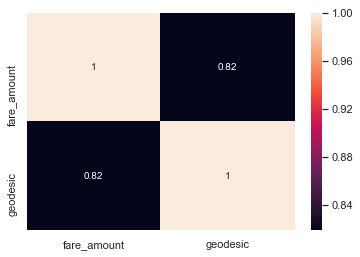

In [58]:
sns.heatmap(corr_train_cab, annot=True)

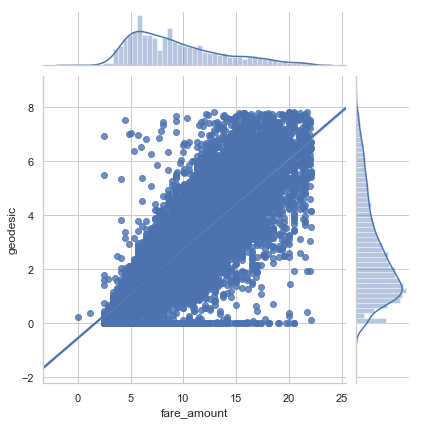

In [59]:
sns.jointplot(x='fare_amount',y='geodesic',data=train_cab,kind = 'reg')
plt.show()

In [60]:
train_cab.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hours,geodesic
count,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000
mean,9.318769,-72.473361,39.898011,-72.463649,39.898540,1.650441,2011.732779,6.262154,3.033035,13.494588,2.560572
std,4.293613,10.543464,6.187321,10.571230,6.186948,1.265426,1.867124,3.447368,1.968920,6.520768,1.765262
min,0.010000,-74.438233,-74.006893,-74.429332,-74.006377,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992157,40.734943,-73.991182,40.734708,1.000000,2010.000000,3.000000,1.000000,9.000000,1.212696
50%,8.500000,-73.981696,40.752633,-73.980165,40.753582,1.000000,2012.000000,6.000000,3.000000,14.000000,2.101870
75%,12.000000,-73.966834,40.767398,-73.963643,40.768027,2.000000,2013.000000,9.000000,5.000000,19.000000,3.588726
max,22.100000,40.766125,41.366138,40.802437,41.366138,6.000000,2015.000000,12.000000,6.000000,23.000000,7.819169


In [61]:
train_cab = train_cab.drop(['pickup_longitude','pickup_latitude'],axis=1)

In [62]:
train_cab = train_cab.drop(['dropoff_longitude','dropoff_latitude'],axis=1)

In [63]:
test_cab = test_cab.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)

In [64]:
model_name = ols('fare_amount ~ passenger_count + hours + day_of_week + month + year', data=train_cab).fit()

In [65]:
model_name.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     84.42
Date:                Sun, 22 Dec 2019   Prob (F-statistic):           7.60e-88
Time:                        02:26:34   Log-Likelihood:                -45759.
No. Observations:               15983   AIC:                         9.153e+04
Df Residuals:                   15977   BIC:                         9.158e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -702.5938     36.383    -19.311      0.000    -773.908    -631.279
passenger_count    -0.0315      0.027     -1.189      0.235      -0.084       0.020
hours              -0.0194      0.005     -3.753      0.000      -0.029      -0.009
day_of_week         0.0395      0.017      2.311      0.021       0.006       0.073
month               0.0612      0.010      6.252      0.000       0.042       0.080
year                0.3538      0.018     19.566      0.000       0.318       0.389
==============================================================================
Omnibus:                     1387.890   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1786.545
Skew:                           0.819   Prob(JB):                         0.00
Kurtosis:                       3.007   Cond. No.                     2.18e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
aov_table = sm.stats.anova_lm(model_name,type = 1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
passenger_count,1.0,19.336470,19.336470,1.076268,2.995497e-01
hours,1.0,301.449555,301.449555,16.778680,4.220957e-05
day_of_week,1.0,98.156205,98.156205,5.463374,1.943140e-02
month,1.0,286.632034,286.632034,15.953937,6.519333e-05
year,1.0,6877.980111,6877.980111,382.828331,2.915080e-84
Residual,15977.0,287046.384249,17.966225,NaN,NaN


# Feature Scaling

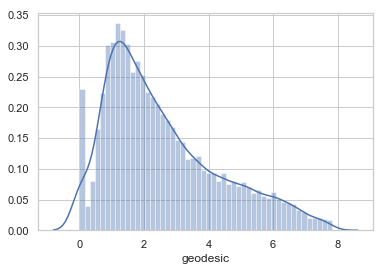

In [67]:
#Feature Scaling Check with or without normalization of standarscalar
sns.distplot(train_cab['geodesic'],bins=50)

((array([-3.92498908, -3.70603239, -3.58609907, ...,  3.58609907,
          3.70603239,  3.92498908]),
  array([0.        , 0.        , 0.        , ..., 7.80656665, 7.81277497,
         7.81916854])),
 (1.7005159796649065, 2.5605722594341924, 0.9631270020406412))

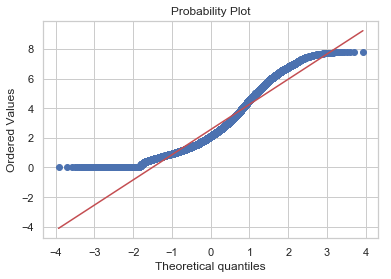

In [68]:
plt.figure()
stats.probplot(train_cab['geodesic'], dist='norm', fit=True,plot=plt)

In [69]:
#Normalization
train_cab['geodesic'] = (train_cab['geodesic'] - min(train_cab['geodesic']))/(max(train_cab['geodesic']) - min(train_cab['geodesic']))
#test.csv['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

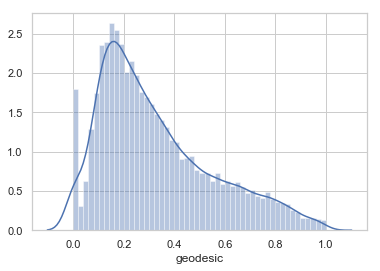

In [70]:
sns.distplot(train_cab['geodesic'],bins=50)

((array([-3.92498908, -3.70603239, -3.58609907, ...,  3.58609907,
          3.70603239,  3.92498908]),
  array([0.        , 0.        , 0.        , ..., 0.99838833, 0.99918232,
         1.        ])),
 (0.21748041006237573, 0.3274737265837552, 0.9631270020406413))

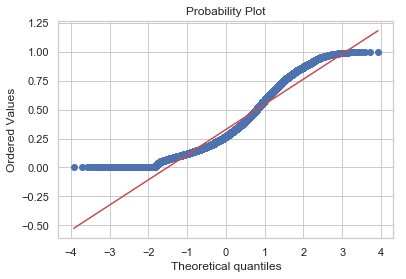

In [71]:
stats.probplot(train_cab['geodesic'], dist='norm', fit=True,plot=plt)


# Splitting train and Validation Dataset

In [72]:
#Splitting Data into train and validation subsets
X = train_cab.drop('fare_amount',axis=1).values
y = train_cab['fare_amount'].values
X_train_cab, X_test_cab, y_train_cab, y_test_cab = train_test_split(X, y, test_size = 0.20, random_state=42)
print(train_cab.shape, X_train_cab.shape, X_test_cab.shape,y_train_cab.shape,y_test_cab.shape)

(15983, 7) (12786, 6) (3197, 6) (12786,) (3197,)


## Model Development 

# Linear Regression Model

In [73]:
def get_score(model, X_train_cab, X_test_cab, y_train_cab, y_test_cab):
    model.fit(X_train_cab, y_train_cab)
    return model.score(X_test_cab,y_test_cab)

In [74]:
print('Linear Regression',get_score(LinearRegression(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('DecisionTreeRegressor',get_score(DecisionTreeRegressor(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('RandomForestRegressor',get_score(RandomForestRegressor(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('XGBRegressor',get_score(XGBRegressor(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))

Linear Regression 0.6840788779220737
DecisionTreeRegressor 0.42861216886189146


/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor 0.6759340271885907
[02:26:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 0.7319002257126387


In [75]:
def RMSE(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(model)
    print('RMSE_test', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('RMSE_train', np.sqrt(mean_squared_error(y_train, y_pred_train)))

In [76]:
print('Linear Regression',RMSE(LinearRegression(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('DecisionTreeRegressor',RMSE(DecisionTreeRegressor(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('RandomForestRegressor',RMSE(RandomForestRegressor(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('XGBRegressor',RMSE(XGBRegressor(), X_train_cab, X_test_cab, y_train_cab, y_test_cab))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE_test 2.3763761075113545
RMSE_train 2.387846886144272
Linear Regression None
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
RMSE_test 3.2113913355286003
RMSE_train 0.013964479679398043
DecisionTreeRegressor None


/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RMSE_test 2.391778634430006
RMSE_train 1.0193118114278026
RandomForestRegressor None
[02:26:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:li

# KFold

In [77]:
folds = StratifiedKFold(n_splits=10)

In [78]:
print('LinearRegression_CV', cross_val_score(LinearRegression(), X, y,cv=5))
print('LinearRegression_CV_mean', cross_val_score(LinearRegression(), X, y,cv=5).mean())

LinearRegression_CV [0.69105989 0.67923199 0.70507178 0.70816572 0.66963886]
LinearRegression_CV_mean 0.6906336465836012


In [79]:
print('DecisionTreeRegressor_CV', cross_val_score(DecisionTreeRegressor(), X, y,cv=5))
print('DecisionTreeRegressor_CV_mean', cross_val_score(DecisionTreeRegressor(), X, y,cv=5).mean())

DecisionTreeRegressor_CV [0.41473104 0.43785047 0.42314935 0.48969521 0.44285117]
DecisionTreeRegressor_CV_mean 0.44390272408573656


In [80]:
print('RandomForestRegressor_CV', cross_val_score(RandomForestRegressor(), X, y,cv=5))
print('RandomForestRegressor_CV_mean', cross_val_score(RandomForestRegressor(), X, y,cv=5).mean())

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anacon

RandomForestRegressor_CV [0.68871075 0.69794725 0.68758802 0.71056422 0.68626248]


/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/divyanggor/anacon

RandomForestRegressor_CV_mean 0.6929728424247361


In [81]:
print('XGBRegressor_CV', cross_val_score(XGBRegressor(), X, y,cv=5))
print('XGBRegressor_CV_mean', cross_val_score(XGBRegressor(), X, y,cv=5).mean())

[02:26:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor_CV [0.74321283 0.73612606 0.74348742 0.75401336 0.73133161]
[02:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

In [86]:
test_cab_1 = test_cab.drop(['pickup_datetime'],axis =1)

In [87]:
def plot_regression(model,X_train, y_train):
    reg_coef_m = model.fit(X_train,y_train).coef_
    print(reg_coef_m)
    # Plot the coefficients
    plt.figure(figsize=(15,5))
    plt.plot(range(len(test_cab_1.columns)), reg_coef_m)
    plt.xticks(range(len(test_cab_1.columns)), test_cab_1.columns.values, rotation=60)
    plt.margins(0.02)   
    plt.show()


[ 1.30126170e-02  3.21479595e-01  4.98992784e-02 -1.44821150e-02
  4.30247742e-03  1.56315774e+01]


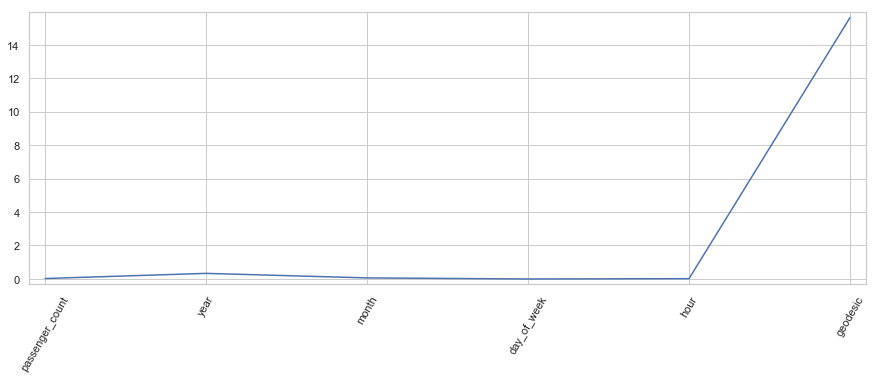

Linear Regression Coefficient Plot None


In [88]:
print('Linear Regression Coefficient Plot', plot_regression(LinearRegression(),X_train_cab,y_train_cab))

In [89]:
def plot_importance(model, X_train_cab, y_train_cab):
    # Creating plot
    fig = plt.figure(figsize=(20,10))
    plt.title(model)
    tree_features = model.fit(X_train_cab,y_train_cab).feature_importances_
    print(tree_features)
    indices = np.argsort(tree_features)[::1]
    names = [test_cab_1.columns[i] for i in indices]
    # Add horizontal bars
    plt.barh(range(pd.DataFrame(X_train_cab).shape[1]),tree_features[indices],align = 'center')
    plt.yticks(range(pd.DataFrame(X_train_cab).shape[1]), names)
    plt.show()

[0.01658948 0.04754824 0.04305918 0.03886508 0.05897136 0.79496666]


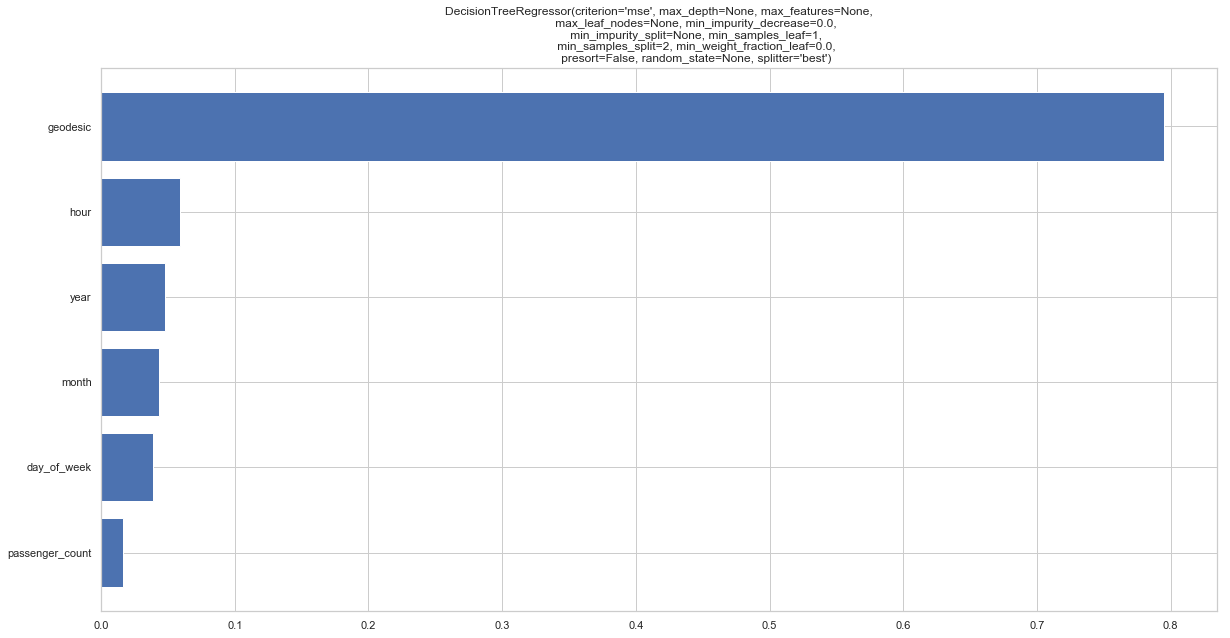

DecisionTreeRegressor None


/Users/divyanggor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.01841511 0.04776641 0.04370657 0.0352596  0.0605814  0.7942709 ]


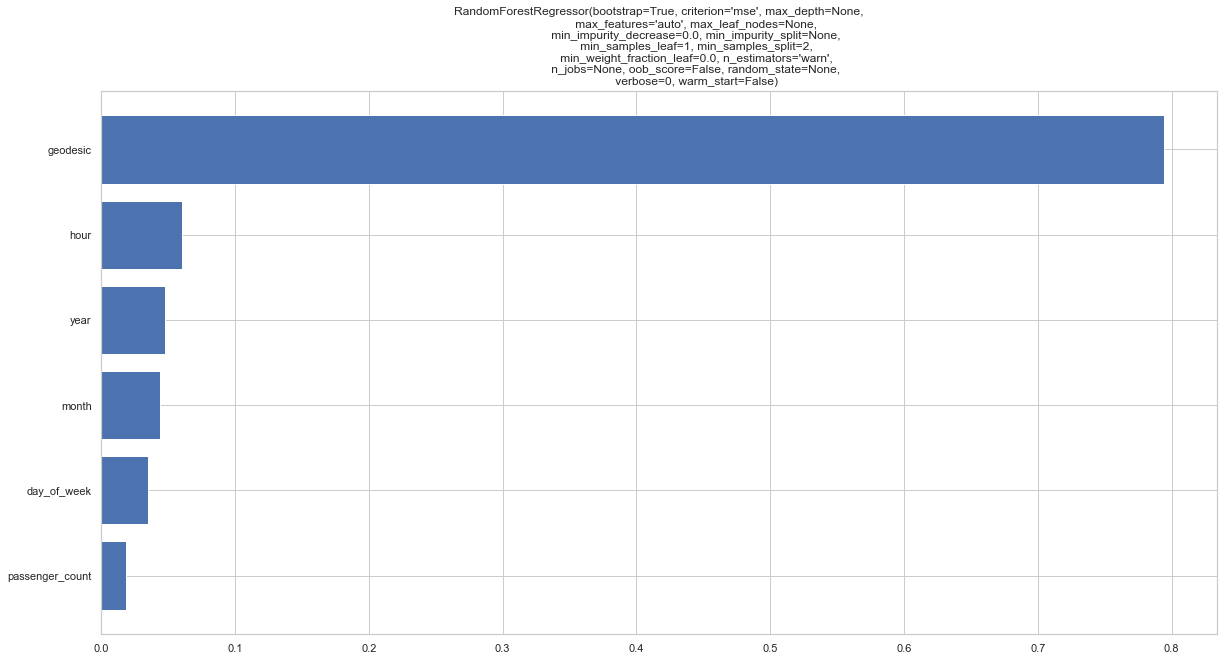

RandomForestRegressor None
[02:30:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.01021647 0.09171061 0.0174886  0.01477069 0.03021676 0.83559686]


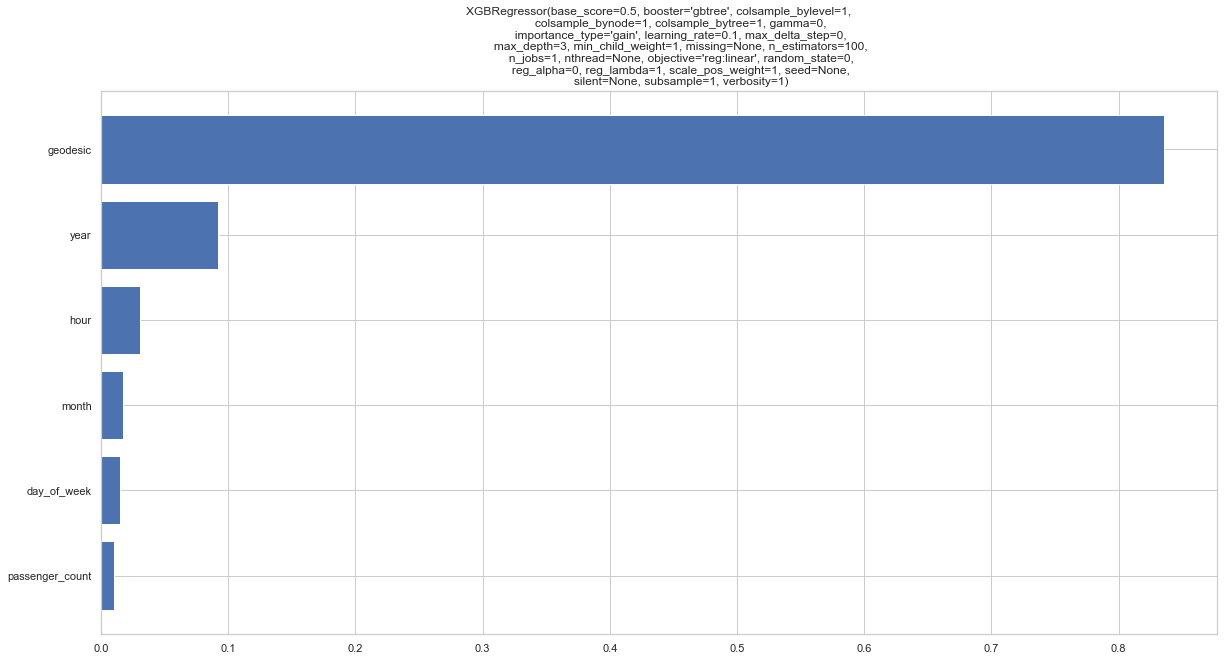

XGBRegressor None


In [91]:
print('DecisionTreeRegressor',plot_importance(DecisionTreeRegressor(),X_train_cab,y_train_cab))
print('RandomForestRegressor',plot_importance(RandomForestRegressor(),X_train_cab,y_train_cab))
print('XGBRegressor',plot_importance(XGBRegressor(),X_train_cab,y_train_cab))

In [92]:
#Improve Accuraccy Using XGBOOST
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train_cab, label=y_train_cab)
dtest = xgb.DMatrix(X_test_cab)

/Users/divyanggor/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [93]:
dtrain,dtest,data_dmatrix

(<xgboost.core.DMatrix at 0x1c33a16e10>,
 <xgboost.core.DMatrix at 0x1c33a16dd8>)

In [94]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[02:30:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.889331,0.008423,8.890325,0.022603
1,8.186906,0.009896,8.187250,0.021307
2,7.527914,0.070565,7.528080,0.043130
3,6.984367,0.074100,6.984897,0.046028
4,6.470686,0.136828,6.471538,0.108298


In [95]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

99    2.297692
Name: test-rmse-mean, dtype: float64


In [96]:
a=pd.read_csv('test.csv')

In [97]:
test_pickup_datetime=a['pickup_datetime']

[02:30:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/divyanggor/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[0.0475603  0.09103161 0.0546175  0.04950772 0.06555132 0.6917316 ]


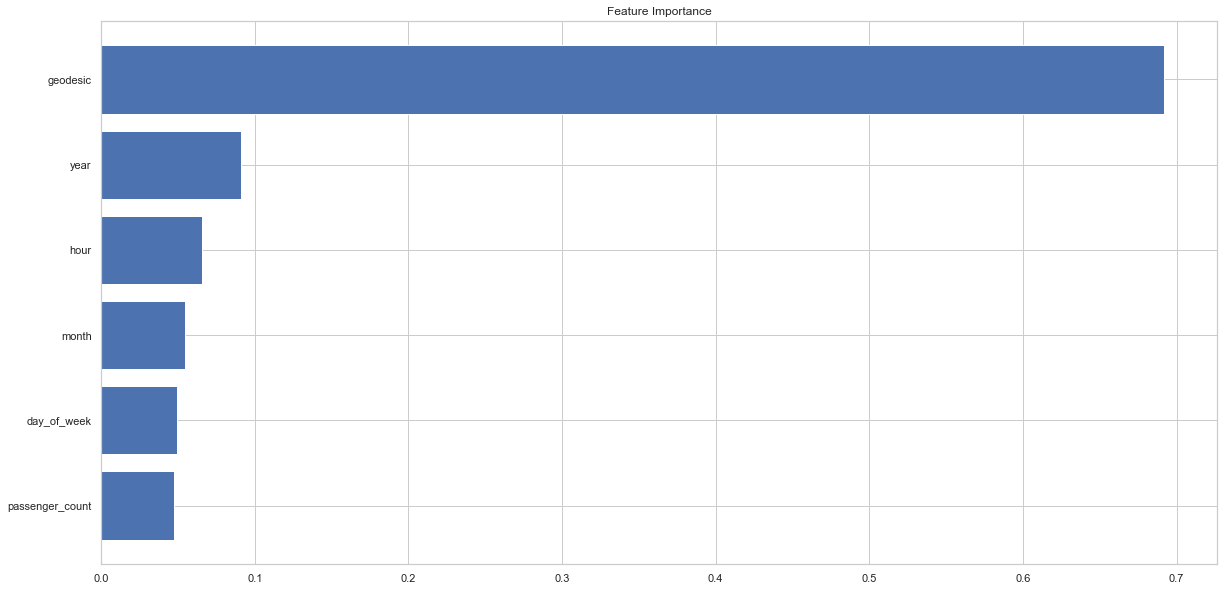

[02:30:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.9000000000000001,
             colsample_bynode=0.7000000000000001,
             colsample_bytree=0.7000000000000001, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.08685113737513521, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.1, verbosity=1)
RMSE_test 2.1955516894225844
RMSE_train 2.113705445258577
[02:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Linear Regression 0.7303281336291445
[02:30:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favo

In [98]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 500, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test_cab_1.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train_cab).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train_cab).shape[1]), names)
plt.savefig(' xgb1 feature importance')
plt.show()
RMSE(Xgb,X_train_cab,X_test_cab,y_train_cab,y_test_cab)
print('Linear Regression',get_score(Xgb, X_train_cab, X_test_cab, y_train_cab, y_test_cab))
print('XGBRegressor_CV', cross_val_score(Xgb, X, y,cv=5))
print('XGBRegressor_CV_mean', cross_val_score(Xgb, X, y,cv=5).mean())

# Predictions
pred = Xgb.predict(test_cab_1.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
pred_results_wrt_date.to_csv("predictions_xgboost.csv",index=False)

In [99]:
pred_results_wrt_date

,pickup_datetime,fare_amount
0,2015-01-27 13:08:24 UTC,19.113100
1,2015-01-27 13:08:24 UTC,19.113100
2,2011-10-08 11:53:44 UTC,14.126828
3,2012-12-01 21:12:12 UTC,15.965385
4,2012-12-01 21:12:12 UTC,15.965385
5,2012-12-01 21:12:12 UTC,15.965385
6,2011-10-06 12:10:20 UTC,16.668480
7,2011-10-06 12:10:20 UTC,17.171066
8,2011-10-06 12:10:20 UTC,17.171066
9,2014-02-18 15:22:20 UTC,19.465405
